# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 01.06.2025**

**Мягкий дедлайн: 14.06.2025 23:59 MSK**

**Жёсткий дедлайн: 16.06.2025 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


![photo_2023-05-17%2020.06.18.jpeg](attachment:photo_2023-05-17%2020.06.18.jpeg)

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [4]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [5]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
     ap = []

     for rel, pred in zip(relevant, predicted):
        pred_k = pred[:k]

        rel_set = set(rel)
        ap_now = 0.0
        num_relevant = 0

        for i in range(len(pred_k)):
            if pred_k[i] in rel_set:
                num_relevant += 1
                ap_now += num_relevant / (i+1)

        ap_now /= min(len(rel), k)
        ap.append(ap_now)

     return np.mean(ap)

In [6]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [7]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [8]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [9]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [10]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [11]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [12]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [13]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [14]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [15]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        """
        param k: int - k best recommendations (как я понял)
        """
        test_preds = []
        n_users = range(self.n_users)

        for user_id in n_users:
          user_rec = self.recommend(user_id)
          test_preds.append(user_rec)

        test_preds = self.remove_train_items(test_preds, k)

        return test_preds[test_users]

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [16]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    jaccard_score = (ratings@user_vector.T)/(np.sum(ratings+user_vector!=0,1))
    jaccard_score[jaccard_score == 1] = -1
    return jaccard_score

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [17]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        sim = np.squeeze(np.asarray(self.similarity_func(self.R,user_vector)))

        thresholds = sim > self.alpha
        true_sim = sim[thresholds]

        res = (true_sim @ self.R[thresholds])/np.sum(thresholds)

        return res

    def recommend(self, uid: int):
        user_uid = self.R[uid]
        sim = self.similarity(user_uid)
        return np.argsort(sim)[::-1]

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [ ]:
from random import sample

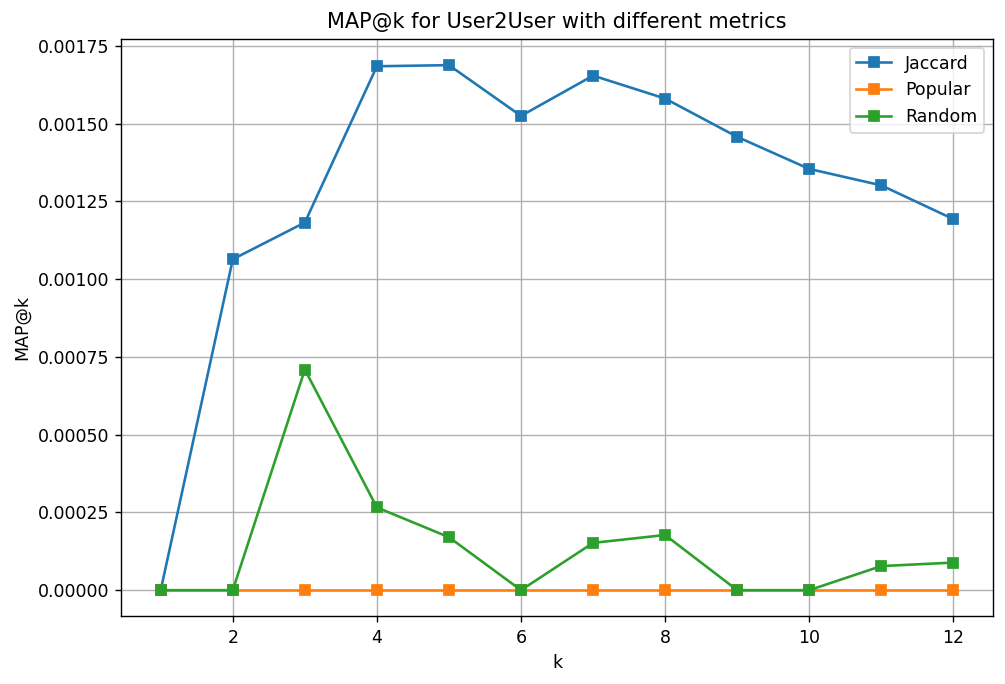

In [ ]:
ks = list(range(1, 13))

model_jac = User2User(train_ratings, jaccard)

map_jaccard = []
map_pop = []
map_random = []

users_list = range(model_jac.n_users)
items = list(range(model_jac.n_items))

for k in ks:
  rec_j = model_jac.get_test_recommendations(k)
  rec_p = [train_ratings.trackId.value_counts(ascending=False).index[:k]]
  rec_r = [sample(items, k) for i in users_list]

  map_j = mapk(test_relevant, rec_j, k)
  map_p = mapk(test_relevant, rec_p, k)
  map_r = mapk(test_relevant, rec_r, k)

  map_jaccard.append(map_j)
  map_pop.append(map_p)
  map_random.append(map_r)

plt.figure(figsize=(9, 6), dpi = 125)
plt.plot(ks, map_jaccard, marker='s', label='Jaccard')
plt.plot(ks, map_pop, marker='s', label='Popular')
plt.plot(ks, map_random, marker='s', label='Random')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k for User2User with different metrics')
plt.legend()
plt.grid()
plt.show()

Лучше всех показал себя мера Жаккара, на втором месте рандомное предсказания и хуже всех показал себя "наивное" предсказание (то есть, когда всем рекомендуем самые популярные треки).

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [18]:
class User2UserCSR(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02
        self.R = scs.csr_matrix(self.R)

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        user_vector = user_vector.toarray()
        sim = np.squeeze(np.asarray(self.similarity_func(self.R,user_vector)))

        thresholds = sim > self.alpha
        true_sim = sim[thresholds]

        res = (true_sim @ self.R[thresholds])/np.sum(thresholds)

        return res

    def recommend(self, uid: int):
        user_uid = self.R[uid]
        sim = self.similarity(user_uid)
        return np.argsort(sim)[::-1]

Теперь сравним за какое время у нас модель учится и предскажет

In [ ]:
%%time
model_before = User2User(train_ratings, jaccard)
pred_before = model_before.get_test_recommendations(15)

CPU times: user 36.7 s, sys: 6.52 s, total: 43.2 s
Wall time: 27.7 s


In [ ]:
%%time
model = User2UserCSR(train_ratings, jaccard)
pred_new = model.get_test_recommendations(15)

CPU times: user 9.92 s, sys: 6.38 s, total: 16.3 s
Wall time: 17.3 s


Действительно стало быстрее

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [ ]:
user_id = np.random.randint(0, model.n_users)

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
62,War,['Edwin Starr']
133,What These Bitches Want,"['DMX', 'Sisqo']"
134,Need A Boss,"['Shareefa', 'Ludacris']"
242,P.I.M.P.,"['50 Cent', 'Snoop Dogg']"
243,P.I.M.P.,['50 Cent']
258,What A Wonderful World,['Louis Armstrong']
313,Where The Hood At,['DMX']
377,Buttons,['The Pussycat Dolls']
392,Someday,['FlipSyde']
393,Happy Birthday,"['FlipSyde', 'Piper']"


In [ ]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
2481,Gangsta's Paradise,"['Coolio', 'L.V.']"
805,Zombie,['The Cranberries']
33436,Believer,['Imagine Dragons']
35656,I Got Love,"['Miyagi & Эндшпиль', 'Рем Дигга']"
29105,Human,"[""Rag'n'Bone Man""]"
48182,Сансара,"['Баста', 'Скриптонит', 'Диана Арбенина', 'Сер..."
18459,Take Me To Church,['Hozier']
1019,It's My Life,['Bon Jovi']
31778,Жить в кайф,['Макс Корж']
35064,Thunder,['Imagine Dragons']


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
53887,Clandestina,"['FILV', 'Edmofo']"
53971,Прочь,"['TERNOVOY', 'AMCHI']"
53993,Til the Light Goes Out,['Lindsey Stirling']
53997,Masquerade,['Lindsey Stirling']
54064,Lies,"['Levianth', 'Maye']"
54065,Музыка звучит,['ХАННА']
54097,Hollywood's Bleeding,['Post Malone']
54220,Roses,['SAINt JHN']
54280,Комета,['JONY']
54503,Elefante,['NK']


### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

Для решения задачи нам нужно использовать векторное дифференцирование, а остальное представить в виде матрицы


**SGD:**

Для Q получаем $Q_{new} =  Q + \eta(R - PQ^T)P^T-\eta\lambda Q$

Для P получаем $P_{new} = P + \eta(R - PQ^T)Q-\eta\lambda P$


**ALS:**

Для Q получаем $(P^TP + λI)R$

Для P получаем $(Q^TQ + λI)R$



**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [19]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            lambda_I = self.lamb * np.eye(self.dim)

            if self.mode == 'sgd':
                R_mask = self.R.nonzero()

                rows, cols = R_mask
                for u, i in zip(rows, cols):
                    r_ui = self.R[u, i]

                    pred = self.P[u] @ self.Q[i]
                    err = r_ui - pred

                    pu = self.P[u].copy()
                    qi = self.Q[i].copy()

                    self.P[u] += self.lr * (err * qi - self.lamb * pu)
                    self.Q[i] += self.lr * (err * pu - self.lamb * qi)

            elif self.mode == 'als':
              lambda_I = self.lamb * np.eye(self.dim)

              # P
              for u in range(self.n_users):
                  item_ids = np.where(self.R[u] > 0)[0]

                  Q_i = self.Q[item_ids]
                  r_u = self.R[u, item_ids]

                  self.P[u] = np.linalg.inv(Q_i.T @ Q_i + lambda_I) @ Q_i.T @ r_u

              # Q
              for i in range(self.n_items):
                  user_ids = np.where(self.R[:, i] > 0)[0]

                  P_u = self.P[user_ids]
                  r_i = self.R[user_ids, i]

                  self.Q[i] = np.linalg.inv(P_u.T @ P_u + lambda_I) @ P_u.T @ r_i

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

Сперва будем перебирать dim, потом k и в конце num_iters

In [ ]:
dim_var = [64, 128, 256]

k = 7

mapk_sgd_list = []
mapk_asl_list = []

for d in dim_var:
    model_sgd = LatentFactorModel(train_ratings, d, 'sgd')
    model_asl = LatentFactorModel(train_ratings, d, 'als')

    model_sgd.fit(num_iters=5)
    model_asl.fit(num_iters=2)

    recomends_sgd = model_sgd.get_test_recommendations(k)
    recomends_asl = model_asl.get_test_recommendations(k)

    mapk_sgd = mapk(test_relevant, recomends_sgd, k)
    mapk_asl = mapk(test_relevant, recomends_asl, k)

    mapk_sgd_list.append(mapk_sgd)
    mapk_asl_list.append(mapk_asl)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

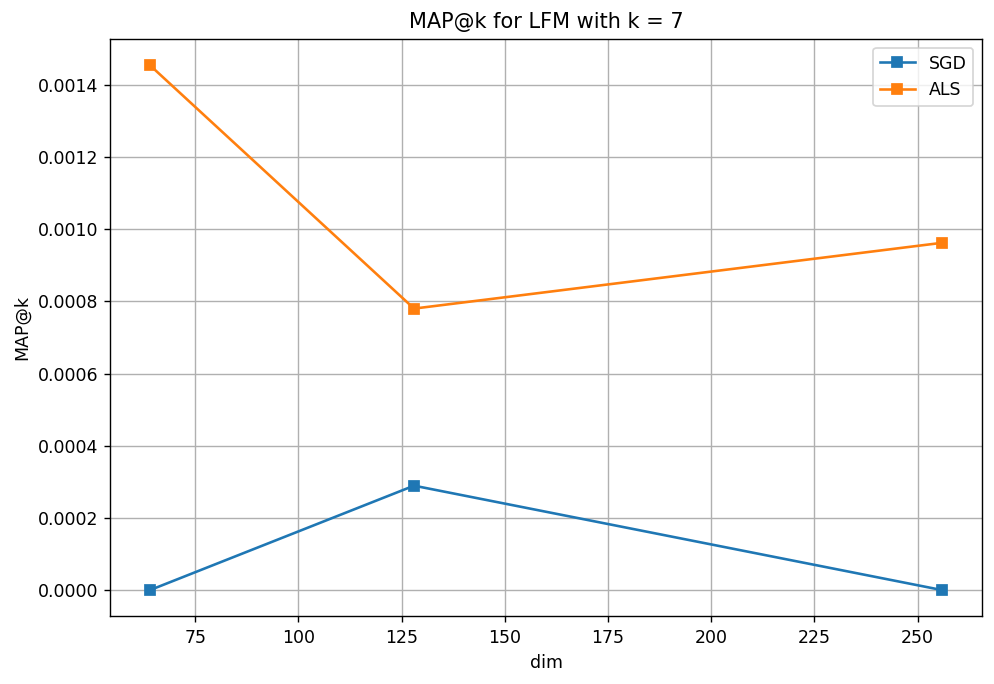

In [ ]:
plt.figure(figsize=(9, 6), dpi = 125)
plt.plot(dim_var, mapk_sgd_list, marker='s', label='SGD')
plt.plot(dim_var, mapk_asl_list, marker='s', label='ALS')

plt.xlabel('dim')
plt.ylabel('MAP@k')
plt.title('MAP@k for LFM with k = 7')
plt.legend()
plt.grid()
plt.show()

Оптиальный dim равен 64 для ALS, для SGD равен 128. Теперь перейдем к подбору k.

In [ ]:
ks = [3, 5, 7, 10]

dim = 64

mapk_sgd_list_k = []
mapk_als_list_k = []

for k in ks:
    model_sgd = LatentFactorModel(train_ratings, 128, 'sgd')
    model_als = LatentFactorModel(train_ratings, dim, 'als')

    model_sgd.fit(num_iters=5)
    model_als.fit(num_iters=2)

    recomends_sgd = model_sgd.get_test_recommendations(k)
    recomends_als = model_als.get_test_recommendations(k)

    mapk_sgd = mapk(test_relevant, recomends_sgd, k)
    mapk_als = mapk(test_relevant, recomends_als, k)

    mapk_sgd_list_k.append(mapk_sgd)
    mapk_als_list_k.append(mapk_als)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

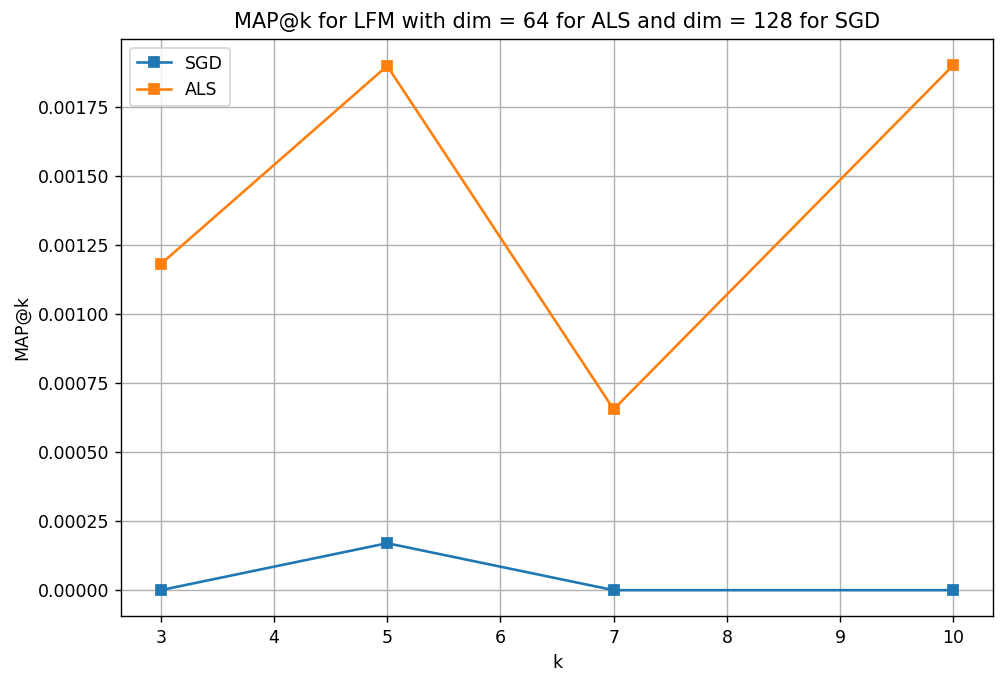

In [ ]:
plt.figure(figsize=(9, 6), dpi = 125)
plt.plot(ks, mapk_sgd_list_k, marker='s', label='SGD')
plt.plot(ks, mapk_als_list_k, marker='s', label='ALS')

plt.xlabel('k')
plt.ylabel('MAP@k')
plt.title('MAP@k for LFM with dim = 64 for ALS and dim = 128 for SGD')
plt.legend()
plt.grid()
plt.show()

Для ALS оптимальный k равен 5. SGD все так же показывает ужасные резуьтаты, но k для него тоже равен 5. Попробуем для ALS и SGD увеличить каличество шагов и посмотерть результат. Кстати у ALS результат уже лучше чем у User2User

In [ ]:
n = [1, 2, 3, 4]

dim = 64

k = 5
mapk_als_list_k_num = []

for i in n:
    model_als = LatentFactorModel(train_ratings, dim, 'als')

    model_als.fit(num_iters=i)

    recommends_als = model_als.get_test_recommendations(k)

    mapk_als = mapk(test_relevant, recommends_als, k)

    mapk_als_list_k_num.append(mapk_als)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

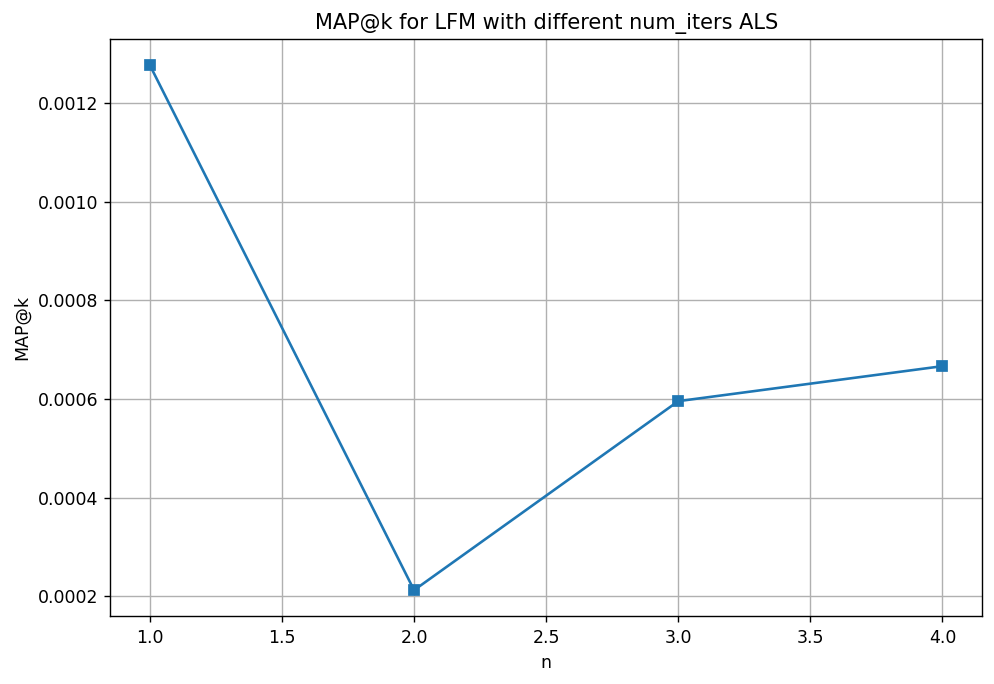

In [ ]:
plt.figure(figsize=(9, 6), dpi = 125)
plt.plot(n, mapk_als_list_k_num, marker='s')

plt.xlabel('n')
plt.ylabel('MAP@k')
plt.title('MAP@k for LFM with different num_iters ALS')
plt.grid()
plt.show()

Почему то теперь k равным единице является оптимальным для ALS. (Хотя тут во многом зависит от random.seed). Теперь сделаем тоже самое для SGD

In [ ]:
n = [5, 10, 15,20]

dim = 128

k = 5
mapk_sgd_list_k_num = []

for i in n:
    model_sgd = LatentFactorModel(train_ratings, dim, 'sgd')

    model_sgd.fit(num_iters=i)

    recommends_sgd = model_sgd.get_test_recommendations(k)

    mapk_sgd = mapk(test_relevant, recommends_sgd, k)

    mapk_sgd_list_k_num.append(mapk_sgd)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

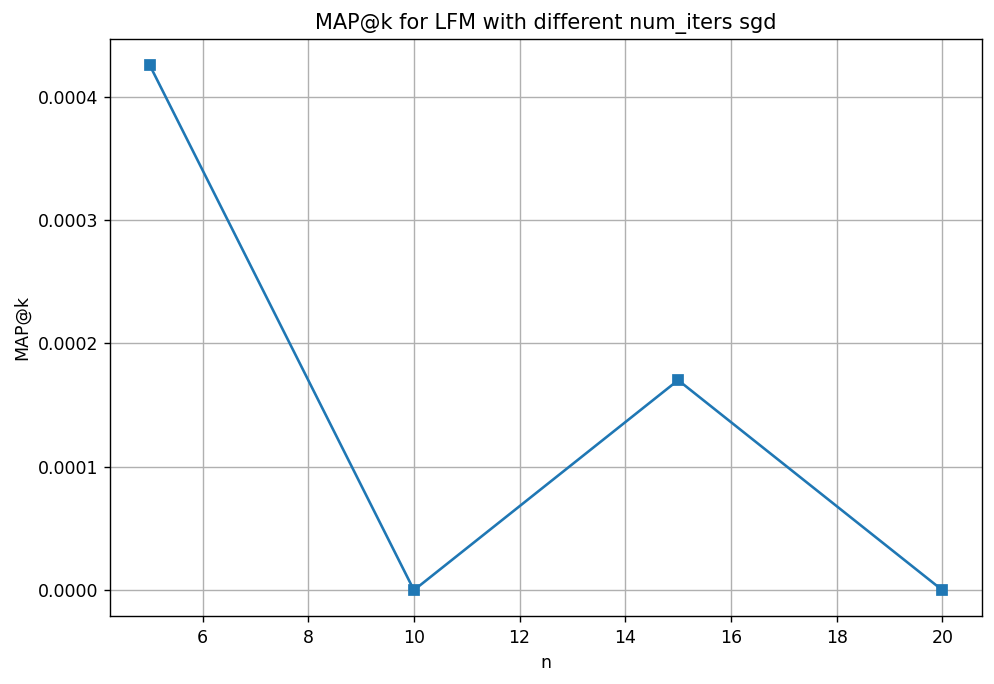

In [ ]:
plt.figure(figsize=(9, 6), dpi = 125)
plt.plot(n, mapk_sgd_list_k_num, marker='s')

plt.xlabel('n')
plt.ylabel('MAP@k')
plt.title('MAP@k for LFM with different num_iters sgd')
plt.grid()
plt.show()

Получаем, что 5 шагов являются самыми оптимальными.

**Итог:** На самом деле из-за того, что нам предлагают взять изначальные P и Q из стандартного нормального распределения, у нас очень сильно могут меняться параметры и в следствии результаты экспериментов. Но в целом ALS дает лучше резальтат чем SGD бесспорно, даже получилось получить качество лучше чем User2User.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
model = LatentFactorModel(train_ratings, 64, 'als')
model.fit(num_iters=1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
5570,Моё сердце,['Сплин'],0.779007
2058,Последний герой,['КИНО'],0.768716
44875,Skibidi,['Little Big'],0.764984
9689,Bicycle Race,['Queen'],0.733643
5153,Stormbringer,['Deep Purple'],0.733643
16637,Zodiac,['Zodiac'],0.733643
27828,Молодые ветра,['7Б'],0.721350
3737,Smoke On The Water,['Deep Purple'],0.701860
7123,Sweet Dreams (Are Made of This),"['Eurythmics', 'Annie Lennox', 'Dave Stewart']",0.695842


В целом неплохо, но то, что Skibidi от little big сюда попал это смешно, ахахахаххаха.

**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

Мне лень выводить аналитическую формулу, да и тут не просят, поэтому буду использовать np.linalg.solve)))

In [20]:
class iALS(BaseModel):
    def __init__(self, ratings, dim=64, alpha=40, lamb=0.1):
        super().__init__(ratings)
        self.dim = dim
        self.alpha = alpha
        self.lamb = lamb

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

    def fit(self, num_iters=10):
        I = np.eye(self.dim)

        for epoch in tqdm(range(num_iters)):
            # P
            for u in range(self.n_users):
                item_ids = np.where(self.R[u] > 0)[0]

                Q_i = self.Q[item_ids]
                C_u = 1 + self.alpha * self.R[u, item_ids]

                Cu_diad = np.diag(C_u)
                A = Q_i.T @ Cu_diad @ Q_i + self.lamb * I
                b = Q_i.T @ (C_u)

                self.P[u] = np.linalg.solve(A, b)

            # Q
            for i in range(self.n_items):
                user_ids = np.where(self.R[:, i] > 0)[0]

                P_u = self.P[user_ids]
                C_i = 1 + self.alpha * self.R[user_ids, i]

                Ci_diag = np.diag(C_i)
                A = P_u.T @ Ci_diag @ P_u + self.lamb * I
                b = P_u.T @ (C_i)

                self.Q[i] = np.linalg.solve(A, b)

    def recommend(self, uid: int):
        scores = self.P[uid] @ self.Q.T
        return np.argsort(scores)[::-1]

In [ ]:
model_ials = iALS(train_ratings, 64, 50, 0.1)
model_ials.fit(num_iters=2)
recomends_ials = model_ials.get_test_recommendations(5)
mapk(test_relevant, recomends_ials, 5)

  0%|          | 0/2 [00:00<?, ?it/s]

np.float64(0.003177304964539008)

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.648009
17331,"Последнее письмо (Гудбай, Америка)",['Nautilus Pompilius'],0.587917
15123,Susanna,['Celentano'],0.580969
5570,Моё сердце,['Сплин'],0.576633
17811,На заре,['Альянс'],0.573954
5153,Stormbringer,['Deep Purple'],0.568725
16637,Zodiac,['Zodiac'],0.568725
9689,Bicycle Race,['Queen'],0.568725
2179,Восьмиклассница,['КИНО'],0.551409


Адекватно работает, надеюсь, что все правильно. По качеству лучше всех остальных моделей, но надо правильно перебирать alpha, я перебирал вручную.

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

Я буду брать ALS, так как он лучше.

In [21]:
from collections import defaultdict

In [62]:
model_u2u = User2User(train_ratings, jaccard)

model_als = LatentFactorModel(train_ratings, dim=64, mode='als')
model_als.fit(num_iters=2)

  0%|          | 0/2 [00:00<?, ?it/s]

In [63]:
als_100 = model_als.get_test_recommendations(100)
u2u_100 = model_u2u.get_test_recommendations(100)

In [64]:
all_recs = als_100 | u2u_100

In [65]:
unique_test_users = test_ratings['userId'].unique()

user_track_pairs = []

for i, (als_tracks, u2u_tracks) in enumerate(zip(als_100, u2u_100)):
    user_id = unique_test_users[i]

    recommended_tracks = set(als_tracks) | set(u2u_tracks)

    user_track_pairs.extend((user_id, track_id) for track_id in recommended_tracks)

recommendations_df = pd.DataFrame(user_track_pairs, columns=['userId', 'trackId'])

In [66]:
recommendations_df.head()

,userId,trackId
0,0,59392
1,0,20996
2,0,14853
3,0,17926
4,0,1034


**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [67]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [78]:
def popularity(df):
    user_counts = df.groupby("trackId")["userId"].nunique()
    uni_users = df["userId"].nunique()
    popularity = (user_counts / uni_users).to_dict()
    return popularity

def activity(df):
    activity = df.groupby("userId")["trackId"].size().to_dict()
    return activity

def last_n_tracks(df: pd.DataFrame, n: int = 50):
    recent_tracks = df.groupby("userId")["trackId"].apply(lambda x: set(x.tail(n)))
    return recent_tracks.to_dict()

Буду использовать recommendations_df, а не train_ratings, так как иначе внизу, в датасете, в колонке label будет ни одной единицы. Также в условии не говориться какой датасет использовать.

In [83]:
track_popularity = popularity(recommendations_df)
user_activity = activity(recommendations_df)
last_tracks = last_n_tracks(recommendations_df)

Теперь будем вывадить фичи

In [84]:
def get_features(df, model_lfm, model_u2u, last_tracks, track_popularity, user_activity):
    P, Q = model_lfm.P, model_lfm.Q
    R = model_u2u.R

    cos_sim_list = []
    mean_jac_list = []
    pop_list = []
    act_list = []
    label_list = []

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
        u = row["userId"]
        i = row["trackId"]

        # Косинусное расстояние
        cos_sim = cosine_similarity(P[u].reshape(1, -1), Q[i].reshape(1, -1))[0, 0]

        # Средняя мера Жаккара
        mean_jac = R[u].mean()

        # Популярность трека
        pop = track_popularity.get(i, 0.0)

        # Активность пользователя
        act = user_activity.get(u, 0)

        # Целевая переменная
        label = int(i in last_tracks.get(u, set()))

        cos_sim_list.append(cos_sim)
        mean_jac_list.append(mean_jac)
        pop_list.append(pop)
        act_list.append(act)
        label_list.append(label)

    df["cos_sim"] = cos_sim_list
    df["mean_jaccard_u2u"] = mean_jac_list
    df["track_popularity"] = pop_list
    df["user_activity"] = act_list
    df["label"] = label_list

    return df

In [85]:
rec_features = get_features(
    recommendations_df.copy(),
    model_als,
    model_u2u,
    last_tracks,
    track_popularity,
    user_activity,
)

Extracting features:   0%|          | 0/44388 [00:00<?, ?it/s]

In [118]:
rec_features.head()

,userId,trackId,cos_sim,mean_jaccard_u2u,track_popularity,user_activity,label
0,0,59392,0.225485,0.00306,0.063830,196,0
1,0,20996,0.295535,0.00306,0.004255,196,0
2,0,14853,0.041369,0.00306,0.004255,196,0
3,0,17926,0.026810,0.00306,0.029787,196,0
4,0,1034,0.138800,0.00306,0.008511,196,0


In [119]:
rec_features.label.value_counts()

,count
label,
0,32638
1,11750


In [88]:
X = rec_features.drop('label', axis=1)
y = rec_features.label

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=2024)

In [90]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.5 MB/s eta 0:00:00


Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ).

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [98]:
train_sort_id = X_train['userId'].argsort()
X_train.iloc[train_sort_id].reset_index(drop=True)
y_train.iloc[train_sort_id].reset_index(drop=True)

test_sort_id = X_test['userId'].argsort()
X_test.iloc[test_sort_id].reset_index(drop=True)
y_test.iloc[test_sort_id].reset_index(drop=True)

,label
0,0
1,0
2,0
3,0
4,0
...,...
17751,0
17752,1
17753,0
17754,1


In [100]:
import catboost

# group_id == user_id here
train_pool = catboost.Pool(X_train, y_train, group_id=X_train['userId'])
test_pool = catboost.Pool(X_test, y_test, group_id=X_test['userId'])

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [101]:
from catboost import CatBoostClassifier

In [121]:
ctb_cls = CatBoostClassifier(verbose=False,random_seed=2024)

ctb_cls.fit(train_pool, eval_set=test_pool)

In [122]:
preds_ctb = []

for id, df in X_test.groupby("userId"):
    probabilities = ctb_cls.predict_proba(df)[:, 1]
    df = df.copy()
    df["pred_prob"] = probabilities
    top_tracks =df.sort_values("pred_prob", ascending=False)["trackId"].tolist()
    preds_ctb.append(top_tracks)

def pred_df(user_ids, predictions):
    return pd.DataFrame({
        "userId": user_ids,
        "preds": [list(p) for p in predictions]
    })

als_pred_df = pred_df(unique_test_users, als_100)
u2u_pred_df = pred_df(unique_test_users, u2u_100)

test_ids = X_test["userId"].unique()
als_pred_df_test = als_pred_df[als_pred_df["userId"].isin(test_ids)].reset_index(drop=True)
u2u_pred_df_test = u2u_pred_df[u2u_pred_df["userId"].isin(test_ids)].reset_index(drop=True)

true_user_tracks = ratings.groupby("userId")["trackId"].apply(list).to_dict()
test_relevant_new = [true_user_tracks.get(user_id, []) for user_id in als_pred_df_test["userId"]]

als_preds = als_pred_df_test["preds"].tolist()
u2u_preds = u2u_pred_df_test["preds"].tolist()

In [123]:
print(f'MAP@20 Catboost: {mapk(test_relevant_new, preds_ctb, k=20)}')
print(f'MAP@20 LFM with ALS: {mapk(test_relevant_new, als_100, k=20)}')
print(f'MAP@20 User2User: {mapk(test_relevant_new, u2u_100, k=20)}')

MAP@20 Catboost: 0.0010417196834593579
MAP@20 LFM with ALS: 0.0011839473452427145
MAP@20 User2User: 0.0016524733911763752


Ну не особо получилось улучшить качетсво, столько пота, чтобы U2U все равно уничтажало все, кроме iALS(((

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

MAP@k был в лекции, так что формално могу оставить его, мне день что-то менять.

In [120]:
from catboost import CatBoostRanker

In [124]:
ctb_ranker = CatBoostRanker(
    eval_metric='MAP:top=20',
    verbose=False,
    random_seed=2024
)

ctb_ranker.fit(train_pool, eval_set=test_pool)

In [131]:
preds_ctb_rank = []

for user_id, group in X_test.groupby('userId'):
    ranks = ctb_ranker.predict(group)

    group = group.copy()
    group = group.reset_index(drop=True)
    group['Rank'] = ranks

    top_tracks = group.sort_values('Rank', ascending=False)['trackId'].tolist()

    preds_ctb_rank.append(top_tracks)

In [132]:
print(f'MAP@20 CatboostClassifier: {mapk(test_relevant_new, preds_ctb, k=20)}')
print(f'MAP@20 CatBoostRanker: {mapk(test_relevant_new, preds_ctb_rank, k=20)}')
print(f'MAP@20 LFM with ALS: {mapk(test_relevant_new, als_100, k=20)}')
print(f'MAP@20 User2User: {mapk(test_relevant_new, u2u_100, k=20)}')

MAP@20 CatboostClassifier: 0.0010417196834593579
MAP@20 CatBoostRanker: 0.000981388053097756
MAP@20 LFM with ALS: 0.0011839473452427145
MAP@20 User2User: 0.0016524733911763752


АХАХХАХАХАХ, в итоге catboost ранкер оказался хуже всех. По итогу могу сказать, что iALS в соло всех вынес, хоть и это бонуска, потом уже U2U. Остальное на подумать...